In [197]:
#!pip install xgboost

In [11]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
pd.options.display.max_columns = None

In [12]:
HOME = Path().resolve().parent.parent
data_dir = str(HOME) + '/data/processed/'

In [19]:
listings = pd.read_csv(data_dir + 'listings_transformed.csv.gz')
listings.shape

(458795, 25)

In [20]:
listings.head()

,availability_60,CasosCovMesAnt,neighbourhood_group_cleansed,longitude,beds,id,bedrooms,accommodates,room_type,number_of_reviews,CasosCovMes,file_date,price,availability_90,amenities,latitude,availability_30,availability_365,review_scores_rating,bathrooms,reviews_per_month,property_type,month,year,is_high_season
0,0,0.0,Sant Martí,2.185545,4,18666,2,6,Entire home/apt,1,0.0,1901,130.0,0,18,41.408886,0,6,80.0,1,0.03,Apartment,1,2019,0
1,27,0.0,Eixample,2.173058,6,18674,3,8,Entire home/apt,5,0.0,1901,60.0,55,22,41.404197,12,326,85.0,2,0.07,Apartment,1,2019,0
2,23,0.0,Horta-Guinardó,2.170701,2,31377,1,2,Private room,4,0.0,1901,42.0,30,26,41.410969,14,184,95.0,1,0.09,Apartment,1,2019,0
3,38,0.0,Horta-Guinardó,2.170819,2,31380,1,3,Private room,39,0.0,1901,53.0,47,26,41.410900,24,204,87.0,1,0.90,Apartment,1,2019,0
4,52,0.0,Gràcia,2.159376,1,31958,1,4,Entire home/apt,151,0.0,1901,60.0,80,10,41.409498,25,342,91.0,1,1.57,Apartment,1,2019,0


### 1. Preparing the dataset to make predictions

In [22]:
useful_features = ['id', 'year', 'month', 'CasosCovMes', 'CasosCovMesAnt', 'beds', 'bedrooms', 
                   'number_of_reviews', 'amenities', 'room_type',  'bathrooms', 'price',
                   'reviews_per_month', 'accommodates', 'review_scores_rating', 'neighbourhood_group_cleansed', 
                  'is_high_season', 'availability_30', 'availability_60']

In [23]:
df = listings[useful_features].groupby(['year', 'month', 'id'], as_index=False).mean()

timeline = df['year']*12 + df['month']
df.insert(2, 'monthly_timeline', timeline)

### 3. Preprocessing data

In [25]:
# This step takes some minutes to finish.

ids = df.id.unique()

df['av60_lag1'] = 0.0
df['av60_lag2'] = 0.0

for id in ids:
    df.loc[df.id == id, 'av60_lag1'] = df[df.id == id]['availability_60'].shift(1)
    df.loc[df.id == id, 'av60_lag2'] = df[df.id == id]['availability_60'].shift(2)

In [26]:
df2 = df.dropna().copy()

In [28]:
df2.shape

(381417, 20)

In [29]:
df2.head()

,year,month,monthly_timeline,id,CasosCovMes,CasosCovMesAnt,beds,bedrooms,number_of_reviews,amenities,bathrooms,price,reviews_per_month,accommodates,review_scores_rating,is_high_season,availability_30,availability_60,av60_lag1,av60_lag2
30754,2019,3,24231,18666,0.0,0.0,4.0,2.0,1.0,18.0,1.0,130.0,0.02,6.0,80.0,0.0,0.0,0.0,0.0,0.0
30755,2019,3,24231,18674,0.0,0.0,6.0,3.0,6.0,22.0,2.0,60.0,0.09,8.0,80.0,0.0,22.0,44.0,31.0,27.0
30758,2019,3,24231,31377,0.0,0.0,2.0,1.0,4.0,26.0,1.0,42.0,0.09,2.0,95.0,0.0,5.0,12.0,16.0,23.0
30759,2019,3,24231,31380,0.0,0.0,2.0,1.0,39.0,26.0,1.0,53.0,0.86,3.0,87.0,0.0,7.0,11.0,15.0,38.0
30760,2019,3,24231,31958,0.0,0.0,1.0,1.0,154.0,10.0,1.0,62.0,1.57,4.0,92.0,0.0,6.0,16.0,36.0,52.0


### 2. Split train and test set

In [30]:
train = df2[df2['monthly_timeline'] <= 24255].copy()
test = df2[df2['monthly_timeline'] > 24255].copy()

In [31]:
X_train, y_train = train.drop('availability_60', axis=1), train['availability_60']
X_test, y_test = test.drop('availability_60', axis=1), test['availability_60']

### 3. Standardization and Normalization

In [32]:
transformer = RobustScaler()
X_train_norm = transformer.fit_transform(X_train)
X_test_norm = transformer.transform(X_test)

### 4. Train XGBoost model

In [33]:
xgb_model = xgb.XGBRegressor()

In [34]:
xgb_model.fit(X_train_norm, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### 5. Predict and validate results

In [35]:
# Predict

train_pred = xgb_model.predict(X_train_norm)
test_pred = xgb_model.predict(X_test_norm)

In [36]:
# Compute RMSE

train_rmse = mean_squared_error(y_train, train_pred)
test_rmse = mean_squared_error(y_test, test_pred)

In [38]:
print(f'The Train RMSE is {train_rmse:.2f}\nThe Test RMSE is {test_rmse:.2f}')

The Train RMSE is 43.75
The Test RMSE is 42.70


### 6. Variable importance for the model

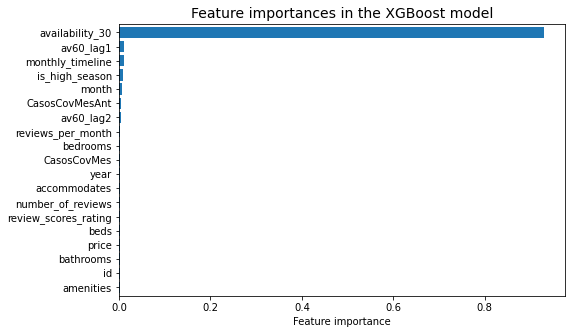

In [39]:
# Producing a dataframe of feature importances
features_weights = pd.DataFrame(xgb_model.feature_importances_, columns=['weight'], index=X_train.columns)
features_weights.sort_values('weight', inplace=True)

# Plotting feature importances
plt.figure(figsize=(8,5))
plt.barh(features_weights.index, features_weights.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()